In [174]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import imageio

In [176]:
filename = 'ski_drop_low.mp4'
vid_reader = imageio.get_reader(filename,  'ffmpeg')
metadata = vid_reader.get_meta_data()
metadata

{'plugin': 'ffmpeg',
 'nframes': inf,
 'ffmpeg_version': '4.2.2 built with gcc 9.2.1 (GCC) 20200122',
 'codec': 'h264',
 'pix_fmt': 'yuv420p(tv',
 'fps': 59.94,
 'source_size': (960, 540),
 'size': (960, 540),
 'duration': 7.57}

In [178]:
vid = []
step = 1
for i, image in enumerate(vid_reader.iter_data()):
    if i % step == 0:
        frame = image[:, :, 0] * 0.2125 + image[:, :, 1] * 0.7154 + image[:, :, 2] * 0.0721
        vid.append(frame[20:, 215:670])  # https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html

vid = np.array(vid, dtype=np.float32)

In [179]:
vid.size, vid.dtype, vid.shape, vid.itemsize  # time by x by y

(107416400, dtype('float32'), (454, 520, 455), 4)

In [180]:
dt = step / metadata["fps"]

# SVD

In [181]:
X = vid.reshape((vid.shape[0], vid.shape[1] * vid.shape[2])).T  # space by time
X1 = X[:, :-1]
X2 = X[:, 1:]

In [182]:
U, S, Vh = np.linalg.svd(X1, full_matrices=False)

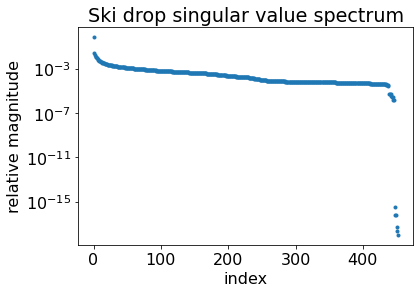

In [185]:
plt.figure()
plt.title("Ski drop singular value spectrum")
plt.xlabel("index")
plt.ylabel("relative magnitude")
plt.semilogy()
plt.plot(S / sum(S), ".")
plt.show()

# DMD

In [150]:
r = 5

Want to solve $AX_1 = X_2$ best fit, but use SVD

In [151]:
A_tilde = U[:, :r].T @ X2 @ Vh[:r].T @ np.diag(1 / S[:r])

In [152]:
lambs, J = np.linalg.eig(A_tilde)

In [153]:
Phi = X2 @ Vh[:r].T @ np.diag(1 / S[:r]) @ J

In [154]:
omegas = np.log(lambs) / dt  # to convert to continuous time

In [155]:
x0 = X[:, 0]
b = np.linalg.pinv(Phi) @ x0

In [156]:
%matplotlib notebook
plt.figure()
plt.plot(np.real(Phi)[:, :3])
plt.show()

<IPython.core.display.Javascript object>

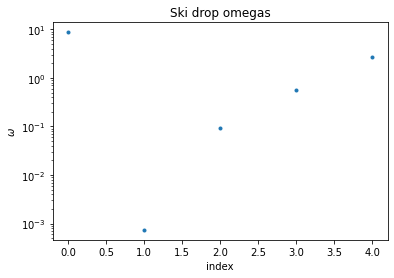

In [157]:
%matplotlib inline
plt.figure()
plt.title("Ski drop omegas")
plt.xlabel("index")
plt.ylabel("$\omega$")
plt.plot(np.absolute(omegas), ".")
plt.semilogy()
plt.show()

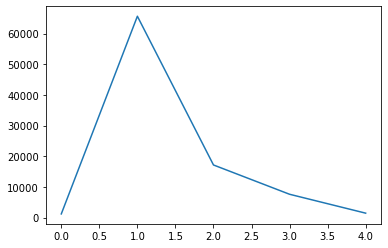

In [158]:
plt.plot(np.absolute(b))

In [159]:
omegas  # if eigenvalues all have large negative real part I don't see the skier

array([-8.7311220e+00-1.6307825e-16j, -7.4046094e-04-1.7341084e-17j,
       -9.4963491e-02+3.3968301e-17j, -5.6020802e-01-2.0311224e-16j,
       -2.6620011e+00+0.0000000e+00j], dtype=complex64)

In [128]:
back_idx = 1
background = b[back_idx] * np.reshape(Phi[:, back_idx], (vid.shape[1], vid.shape[2]))

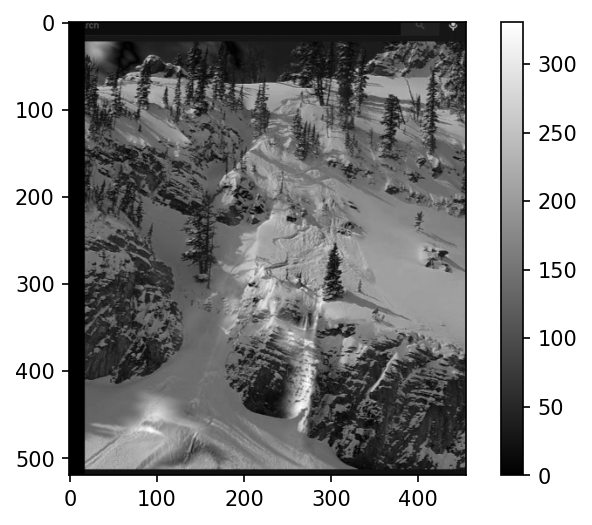

In [162]:
plt.figure(dpi=150)
plt.imshow(np.absolute(background), cmap="gray")
plt.colorbar()

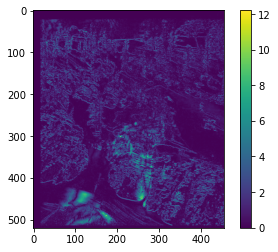

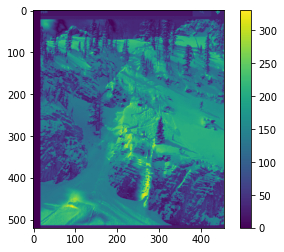

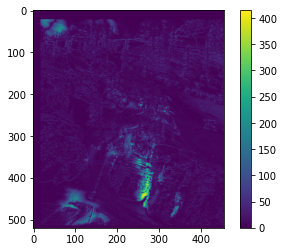

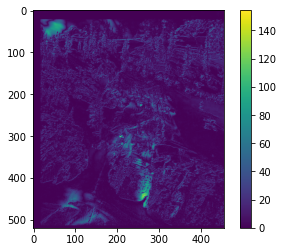

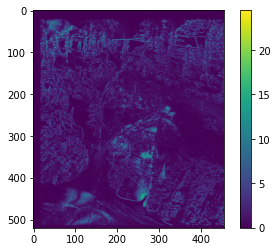

In [161]:
for i in range(len(b)):
    frame = b[i] * np.reshape(Phi[:, i], (vid.shape[1], vid.shape[2]))
    plt.imshow(np.absolute(frame))
    plt.colorbar()
    plt.show()

In [132]:
time_dynamics = np.zeros((r, vid.shape[0]), dtype=np.complex64)
for i in range(0, vid.shape[0]):
    t = i * dt
    time_dynamics[:, i] = b * np.exp(omegas * t)
reconX = Phi @ time_dynamics

In [134]:
recon_vid = reconX.T.reshape((vid.shape[0], *vid.shape[1:]))

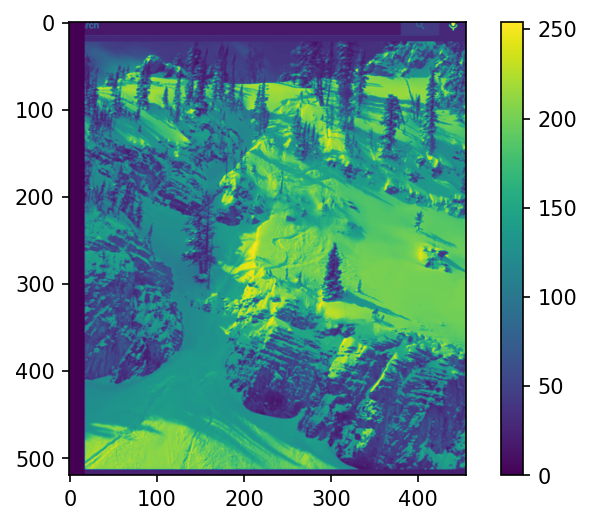

In [135]:
plt.figure(dpi=150)
plt.imshow(np.absolute(recon_vid[1]))
plt.colorbar()

## Foreground Extraction (backround subtraction)

In [163]:
foreground_vid = -(vid - np.absolute(background))

In [164]:
# R is negative
R = np.where(foreground_vid < 0, foreground_vid, 0)  # contains all the negative values of foreground vid, otherwise 0

In [165]:
foreground_vid -= R

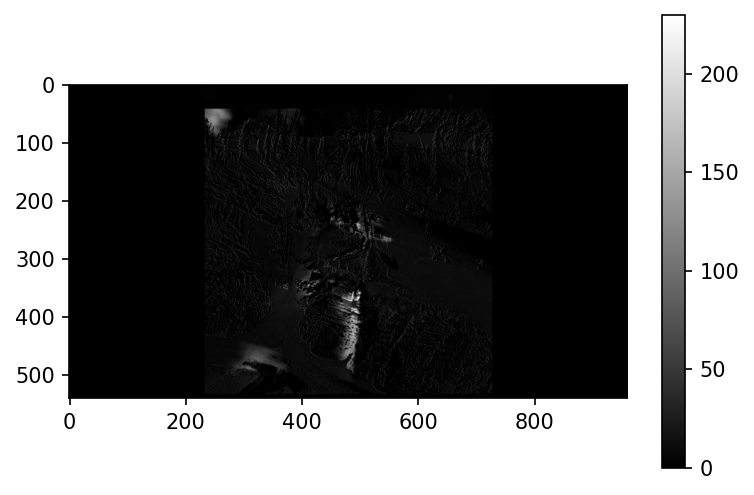

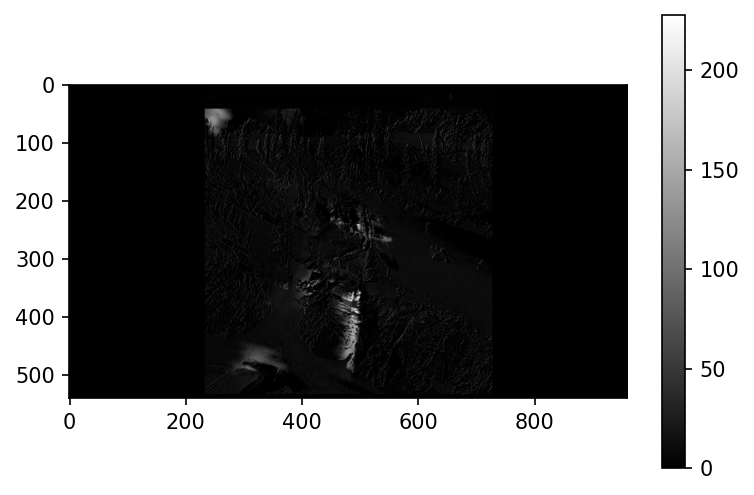

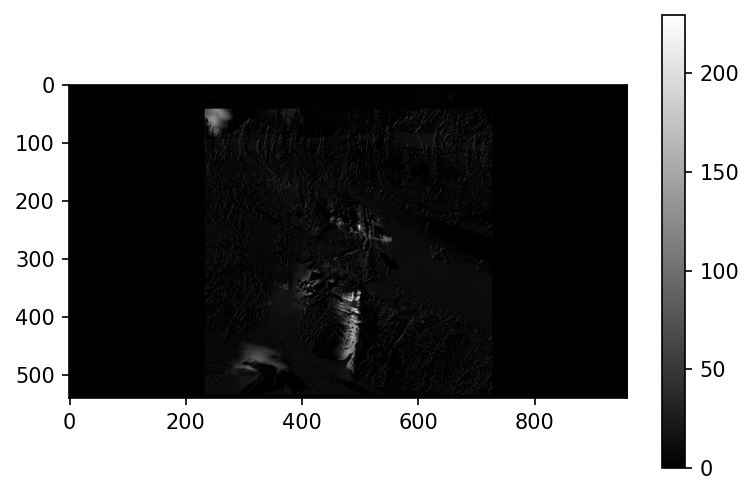

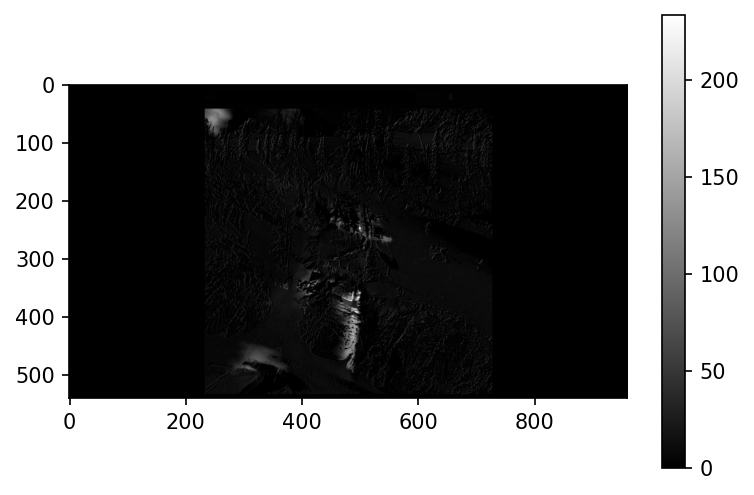

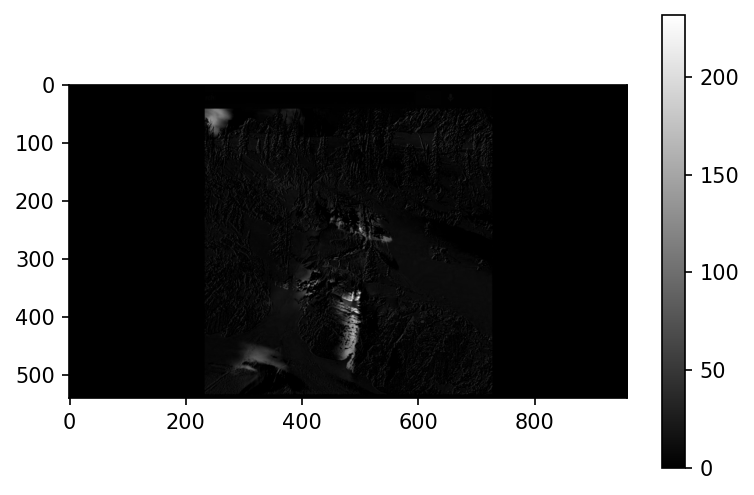

In [167]:
for i in range(35, 40, 1):
    plt.figure(dpi=150)
    plt.imshow(foreground_vid[i], cmap="gray")
    plt.colorbar()

Text(0.5, 1.0, 'ski drop DMD $\\omega$s')

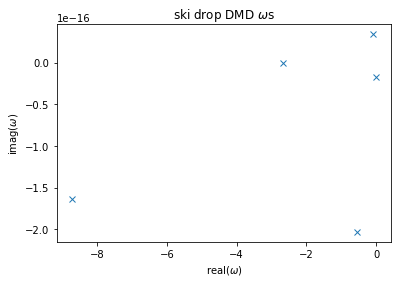

In [160]:
plt.plot(np.real(omegas), np.imag(omegas), "x")
plt.xlabel("real($\omega$)")
plt.ylabel("imag($\omega$)")
plt.title("ski drop DMD $\omega$s")

# MONTE CARLO ANALYSIS

In [166]:
filename = "monte_carlo_low.mp4"
vid_reader = imageio.get_reader(filename,  'ffmpeg')
metadata = vid_reader.get_meta_data()
metadata

{'plugin': 'ffmpeg',
 'nframes': inf,
 'ffmpeg_version': '4.2.2 built with gcc 9.2.1 (GCC) 20200122',
 'codec': 'h264',
 'pix_fmt': 'yuv420p(tv',
 'fps': 59.94,
 'source_size': (960, 540),
 'size': (960, 540),
 'duration': 6.32}

In [167]:
vid = []
step = 1
for i, image in enumerate(vid_reader.iter_data()):
    if i % step == 0:
        vid.append(image[:, :, 0] * 0.2125 + image[:, :, 1] * 0.7154 + image[:, :, 2] * 0.0721)  # https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html

vid = np.array(vid, dtype=np.float32)  #  DWOIJT

In [168]:
vid.size, vid.dtype, vid.shape, vid.itemsize  # time by x by y

(196473600, dtype('float32'), (379, 540, 960), 4)

In [169]:
dt = step / metadata["fps"]

# SVD

In [170]:
X = vid.reshape((vid.shape[0], vid.shape[1] * vid.shape[2])).T  # space by time
X1 = X[:, :-1]
X2 = X[:, 1:]

In [171]:
U, S, Vh = np.linalg.svd(X1, full_matrices=False)

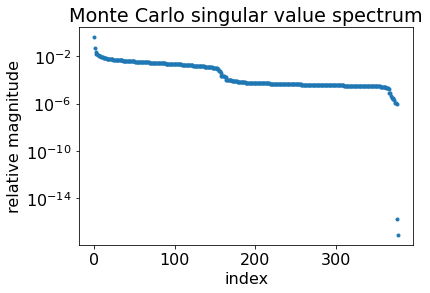

In [175]:
plt.title("Monte Carlo singular value spectrum")
plt.xlabel("index")
plt.ylabel("relative magnitude")
plt.semilogy()
plt.plot(S / sum(S), ".")
plt.show()

# DMD

In [30]:
r = 5

Want to solve $AX_1 = X_2$ best fit, but use SVD

In [31]:
A_tilde = U[:, :r].T @ X2 @ Vh[:r].T @ np.diag(1 / S[:r])

In [32]:
lambs, J = np.linalg.eig(A_tilde)

In [33]:
Phi = X2 @ Vh[:r].T @ np.diag(1 / S[:r]) @ J

In [34]:
omegas = np.log(lambs) / dt  # to convert to continuous time

In [35]:
x0 = X[:, 0]
b = np.linalg.pinv(Phi) @ x0

<IPython.core.display.Javascript object>


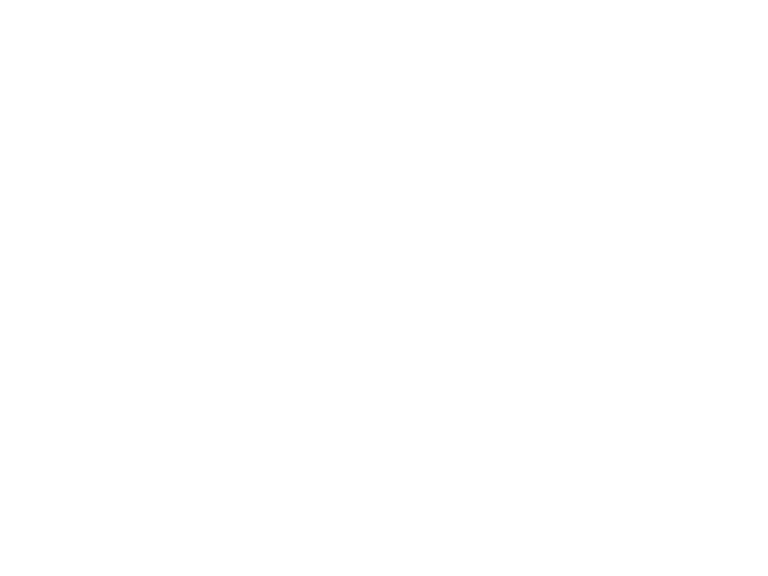

In [36]:
%matplotlib notebook
plt.figure()
plt.plot(np.real(Phi)[:, :3])
plt.show()

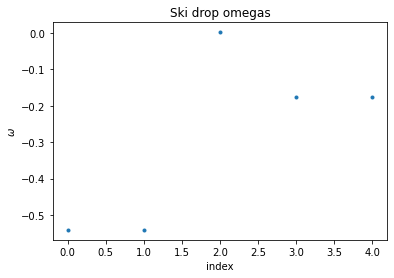

In [37]:
%matplotlib inline
plt.figure()
plt.title("Ski drop omegas")
plt.xlabel("index")
plt.ylabel("$\omega$")
plt.plot(np.real(omegas), ".")
plt.show()

In [38]:
omegas  # if eigenvalues all have large negative real part I don't see the skier

array([-0.5409097 +2.5586112j , -0.5409097 -2.5586112j ,
        0.00171487+0.j        , -0.17537312+0.69354516j,
       -0.17537312-0.69354516j], dtype=complex64)

In [56]:
back_idx = 2
background = b[back_idx] * np.reshape(Phi[:, back_idx], (vid.shape[1], vid.shape[2]))

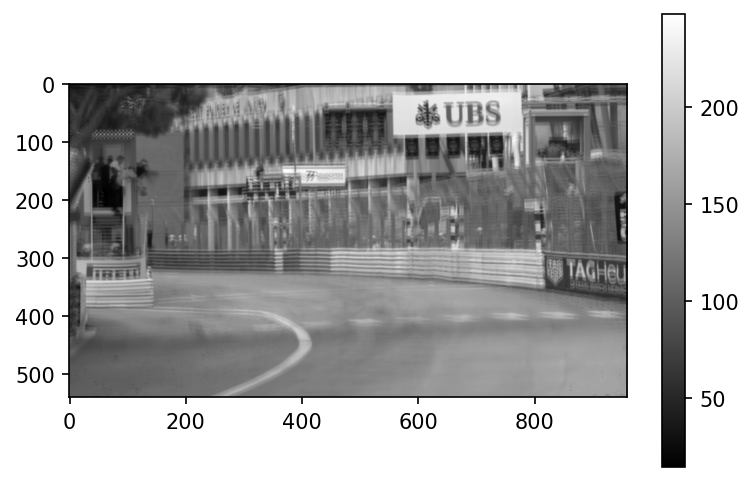

In [57]:
plt.figure(dpi=150)
plt.imshow(np.absolute(background), cmap="gray")
plt.colorbar()

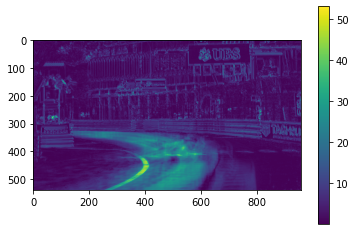

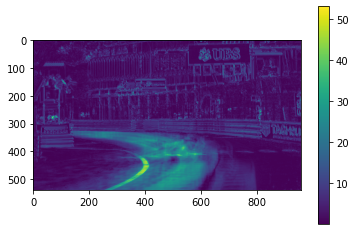

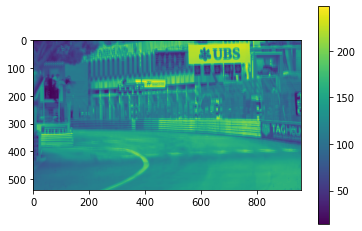

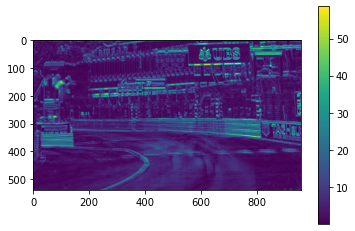

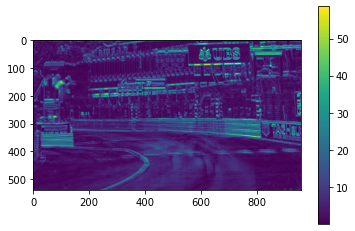

In [58]:
for i in range(len(b)):
    frame = b[i] * np.reshape(Phi[:, i], (vid.shape[1], vid.shape[2]))
    plt.imshow(np.absolute(frame))
    plt.colorbar()
    plt.show()

C:\Python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


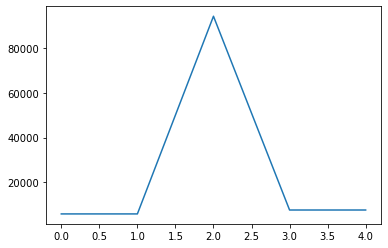

In [60]:
plt.plot(b)

In [61]:
time_dynamics = np.zeros((r, vid.shape[0]), dtype=np.complex64)
for i in range(0, vid.shape[0]):
    t = i * dt
    time_dynamics[:, i] = b * np.exp(omegas * t)
reconX = Phi @ time_dynamics

In [63]:
recon_vid = reconX.T.reshape((vid.shape[0], *vid.shape[1:]))

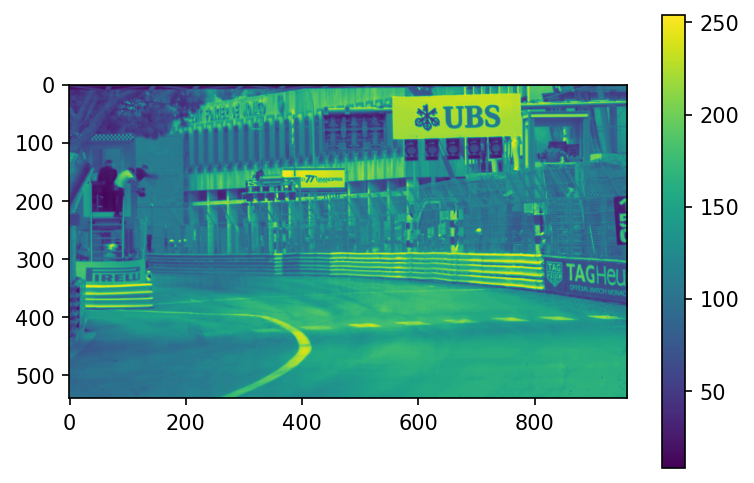

In [64]:
plt.figure(dpi=150)
plt.imshow(np.absolute(recon_vid[0]))
plt.colorbar()

## Foreground Extraction (backround subtraction)

In [68]:
foreground_vid = np.absolute(vid - np.absolute(background))

In [71]:
plt.close("all")

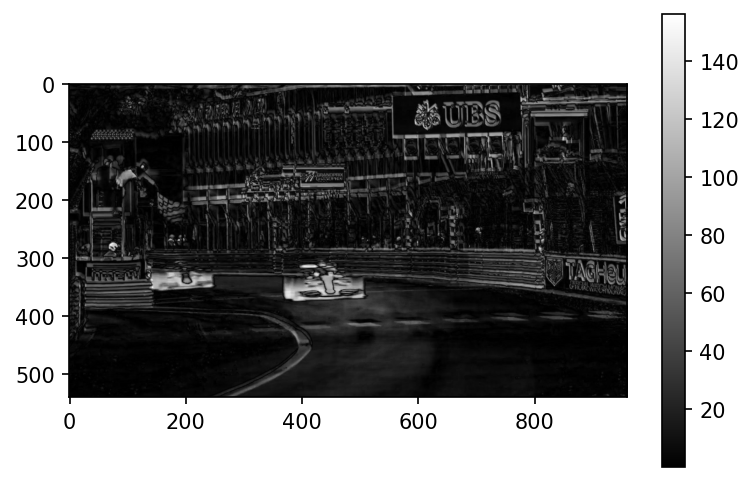

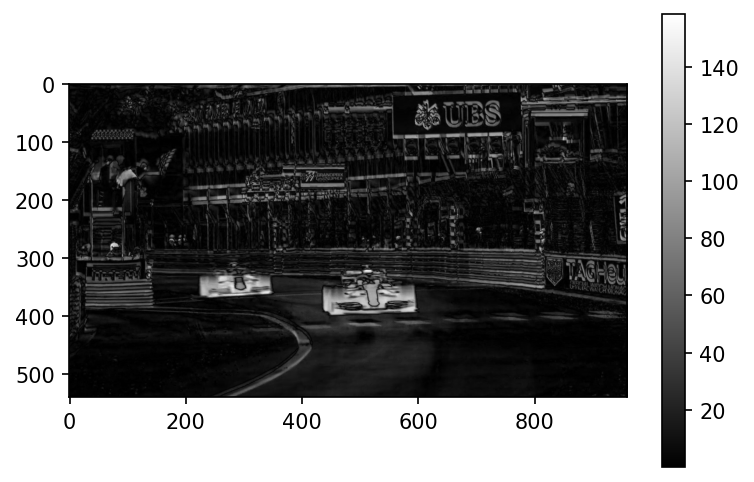

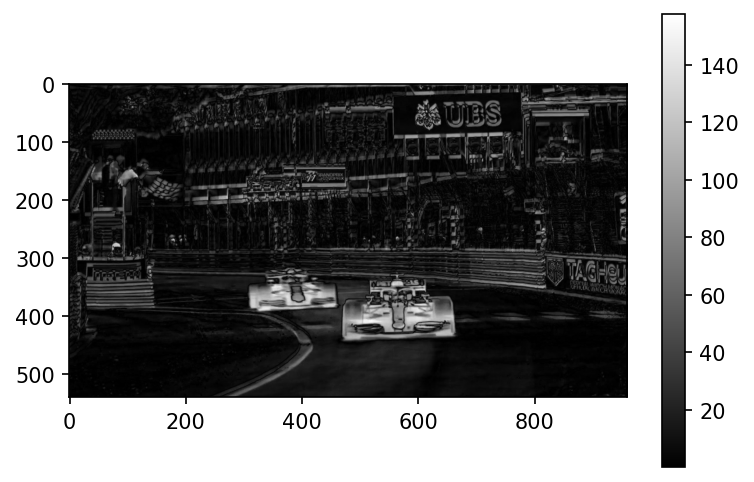

In [74]:
for i in range(0, 60, 20):
    plt.figure(dpi=150)
    plt.imshow(foreground_vid[i], cmap="gray")
    plt.colorbar()

Text(0.5, 1.0, 'monte carlo DMD $\\omega$s')

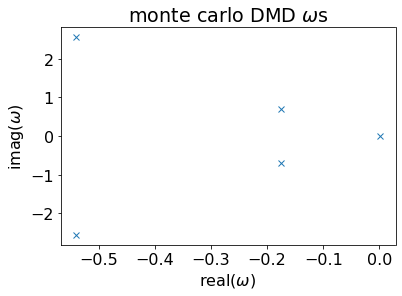

In [93]:
plt.plot(np.real(omegas), np.imag(omegas), "x")
plt.xlabel("real($\omega$)")
plt.ylabel("imag($\omega$)")
plt.title("monte carlo DMD $\omega$s")